In [353]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point, box
import datetime as dt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import SplineTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from numpy import trapz
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from numpy import interp

In [211]:
nodes = pd.read_csv("node_data.csv")
edges = pd.read_csv("edges_data.csv")
df_2020 = pd.read_csv("data/scats_detector_volume_jan-jun-2020.csv")
sites = pd.read_csv("data/its_scats_sites_aug-2020.csv")
columns_to_load = ["End_Time", "Site", "Detector", "Sum_Volume", "Avg_Volume"]
March2025 = pd.read_csv("data/SCATSMarch2025.csv", usecols=columns_to_load)
April2025 = pd.read_csv("data/SCATSApril2025.csv", usecols=columns_to_load)
May2025 = pd.read_csv("data/SCATSMay2025.csv", usecols=columns_to_load)
July2024 = pd.read_csv("data/SCATSJuly2024.csv", usecols=columns_to_load)   
August2024 = pd.read_csv("data/SCATSAugust2024.csv", usecols=columns_to_load)   
Sep2024 = pd.read_csv("data/SCATSSeptember2024.csv", usecols=columns_to_load) 
Oct2024 = pd.read_csv("data/SCATSOctober2024.csv", usecols=columns_to_load) 

In [212]:
df  = pd.concat([July2024,August2024, Sep2024, Oct2024, March2025, April2025], ignore_index=True)
geo_edges=edges.copy()
# Convert the 'geometry' column from WKT to Shapely geometries
geo_edges['geometry'] = edges['geometry'].apply(wkt.loads)

# Wrap as a GeoDataFrame
geo_edges = gpd.GeoDataFrame(geo_edges, geometry='geometry')

# Set the CRS (optional, replace with your CRS if known)
geo_edges.set_crs(epsg=4326, inplace=True)

# Now this is a true GeoDataFrame
print(type(geo_edges))
geo_nodes=nodes.copy()
# Convert the 'geometry' column from WKT to Shapely geometries
geo_nodes['geometry'] = nodes['geometry'].apply(wkt.loads)

# Wrap as a GeoDataFrame
geo_nodes = gpd.GeoDataFrame(geo_nodes, geometry='geometry')

# Set the CRS (optional, replace with your CRS if known)
geo_nodes.set_crs(epsg=4326, inplace=True)

# Now this is a true GeoDataFrame
print(type(geo_nodes))
sites = sites[~((sites["Lat"] == 0) | (sites["Long"] == 0))]
geo_sites = gpd.GeoDataFrame(
    sites,
    geometry=gpd.points_from_xy(sites['Long'], sites['Lat']),
    crs="EPSG:4326"  # WGS84 coordinate system (lat/long)
)
# Get bounding box of all points
minx, miny, maxx, maxy = geo_edges.total_bounds

# Define grid size (in the CRS units, e.g., degrees if EPSG:4326)
nx = 10  # number of columns
ny = 10  # number of rows
xgrid = np.linspace(minx, maxx, nx+1)
ygrid = np.linspace(miny, maxy, ny+1)

# Create grid polygons
polygons = []
for i in range(nx):
    for j in range(ny):
        polygons.append(box(xgrid[i], ygrid[j], xgrid[i+1], ygrid[j+1]))

grid = gpd.GeoDataFrame({'geometry': polygons}, crs=geo_edges.crs)
df_small = df[["End_Time","Site","Detector","Sum_Volume"]]  # only necessary columns
geo_small = geo_sites[['SiteID', 'geometry']]
df_small['Site'] = df_small['Site'].astype('category')
geo_small['SiteID'] = geo_small['SiteID'].astype('category')
gdf = pd.merge(df_small, geo_small, left_on ="Site", right_on = "SiteID", how = "inner")
gdf=gdf.drop("SiteID", axis = 1)
gdf["End_Time"] = pd.to_datetime(gdf["End_Time"], format="%Y%m%d%H%M%S")
gdf = gpd.GeoDataFrame(
    gdf,
    geometry=gdf["geometry"],
    crs="EPSG:4326"  # WGS84 coordinate system (lat/long)
)
gdf.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>


C:\Users\user1\AppData\Local\Temp\ipykernel_10676\967086123.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small['Site'] = df_small['Site'].astype('category')
c:\Users\user1\AppData\Local\Programs\Python\Python313\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,End_Time,Site,Detector,Sum_Volume,geometry
0,2024-07-30 21:00:00,6162,2.0,152.0,POINT (-6.25044 53.29428)
1,2024-07-30 21:00:00,6175,1.0,260.0,POINT (-6.12612 53.23552)
2,2024-07-30 21:00:00,6175,2.0,221.0,POINT (-6.12612 53.23552)
3,2024-07-30 21:00:00,6175,3.0,264.0,POINT (-6.12612 53.23552)
4,2024-07-30 21:00:00,6175,4.0,62.0,POINT (-6.12612 53.23552)


In [213]:
May_small = May2025[["End_Time","Site","Detector","Sum_Volume"]]  # only necessary columns
geo_small = geo_sites[['SiteID', 'geometry']]
May_small['Site'] = May_small['Site'].astype('category')
geo_small['SiteID'] = geo_small['SiteID'].astype('category')
gdf_May = pd.merge(May_small, geo_small, left_on ="Site", right_on = "SiteID", how = "inner")
gdf_May=gdf_May.drop("SiteID", axis = 1)
gdf_May["End_Time"] = pd.to_datetime(gdf_May["End_Time"], format="%Y%m%d%H%M%S")
gdf_May = gpd.GeoDataFrame(
    gdf_May,
    geometry=gdf_May["geometry"],
    crs="EPSG:4326"  # WGS84 coordinate system (lat/long)
)
gdf_May.head()

C:\Users\user1\AppData\Local\Temp\ipykernel_10676\3299648080.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  May_small['Site'] = May_small['Site'].astype('category')
c:\Users\user1\AppData\Local\Programs\Python\Python313\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,End_Time,Site,Detector,Sum_Volume,geometry
0,2025-05-26 02:00:00,403,21,0,POINT (-6.25345 53.34944)
1,2025-05-26 02:00:00,403,22,0,POINT (-6.25345 53.34944)
2,2025-05-26 02:00:00,403,23,0,POINT (-6.25345 53.34944)
3,2025-05-26 02:00:00,403,24,0,POINT (-6.25345 53.34944)
4,2025-05-26 02:00:00,404,1,2,POINT (-6.29184 53.34775)


In [214]:
joined_may = gpd.sjoin(gdf_May, grid, how='left', predicate='within')
joined_may = joined_may.rename(columns={"index_right": "Grid_ID"})
joined_may.head()

,End_Time,Site,Detector,Sum_Volume,geometry,Grid_ID
0,2025-05-26 02:00:00,403,21,0,POINT (-6.25345 53.34944),54.0
1,2025-05-26 02:00:00,403,22,0,POINT (-6.25345 53.34944),54.0
2,2025-05-26 02:00:00,403,23,0,POINT (-6.25345 53.34944),54.0
3,2025-05-26 02:00:00,403,24,0,POINT (-6.25345 53.34944),54.0
4,2025-05-26 02:00:00,404,1,2,POINT (-6.29184 53.34775),34.0


In [215]:
# Spatial join points to grid boxes
joined = gpd.sjoin(gdf, grid, how='left', predicate='within')
joined = joined.rename(columns={"index_right": "Grid_ID"})

# Sum Sum_volume per grid cell
grid_sum = joined.groupby('Grid_ID')['Sum_Volume'].sum()

# Assign sums to the grid GeoDataFrame
grid['Sum_volume'] = grid_sum
grid['Sum_volume'] = grid['Sum_volume'].fillna(0)  # fill empty cells
joined.head()

,End_Time,Site,Detector,Sum_Volume,geometry,Grid_ID
0,2024-07-30 21:00:00,6162,2.0,152.0,POINT (-6.25044 53.29428),NaN
1,2024-07-30 21:00:00,6175,1.0,260.0,POINT (-6.12612 53.23552),NaN
2,2024-07-30 21:00:00,6175,2.0,221.0,POINT (-6.12612 53.23552),NaN
3,2024-07-30 21:00:00,6175,3.0,264.0,POINT (-6.12612 53.23552),NaN
4,2024-07-30 21:00:00,6175,4.0,62.0,POINT (-6.12612 53.23552),NaN


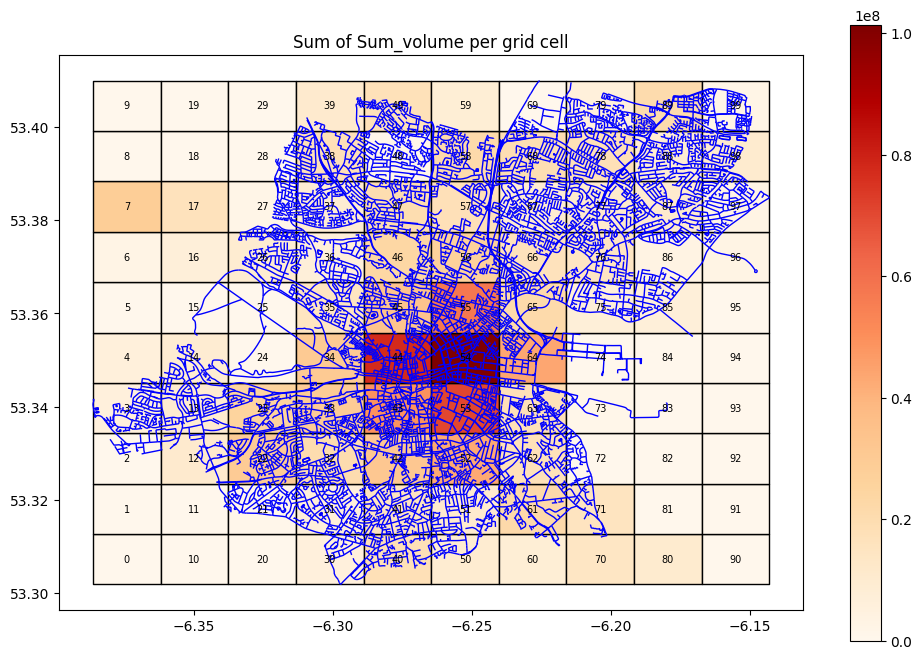

In [216]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
grid.plot(column='Sum_volume', ax=ax, cmap='OrRd', legend=True, edgecolor='k')
geo_edges.plot(ax=ax, color='blue', linewidth=1, label='Edges')

for idx, row in grid.iterrows():
    if row.geometry is not None and not row.geometry.is_empty:
        x, y = row.geometry.centroid.coords[0]
        ax.text(x, y, str(row.name), fontsize=7, color="black",
                ha="center", va="center")
        
plt.title("Sum of Sum_volume per grid cell")
plt.show()

In [217]:
joined_eval = joined.groupby(["Grid_ID","End_Time"]).agg({
    "Sum_Volume": "sum"
}).reset_index()
joined_eval = joined_eval.sort_values("Grid_ID")
joined_eval.head()

,Grid_ID,End_Time,Sum_Volume
0,3.0,2024-07-01 00:00:00,843.0
1,3.0,2024-07-01 01:00:00,627.0
2,3.0,2024-07-01 02:00:00,340.0
3,3.0,2024-07-01 03:00:00,241.0
4,3.0,2024-07-01 04:00:00,183.0


In [218]:
may_eval = joined_may.groupby(["Grid_ID","End_Time"]).agg({
    "Sum_Volume": "sum"
}).reset_index()
may_eval = may_eval.sort_values("Grid_ID")
may_eval.head()

,Grid_ID,End_Time,Sum_Volume
0,3.0,2025-05-01 00:00:00,626
1,3.0,2025-05-01 01:00:00,377
2,3.0,2025-05-01 02:00:00,200
3,3.0,2025-05-01 03:00:00,148
4,3.0,2025-05-01 04:00:00,127


In [219]:
may_eval["Vol_diff"] = may_eval["Sum_Volume"].diff().fillna(0)
may_eval['weekday'] = may_eval["End_Time"].dt.dayofweek
may_eval=may_eval[~may_eval["Grid_ID"].isin([72,73])]
may_eval.head()

,Grid_ID,End_Time,Sum_Volume,Vol_diff,weekday
0,3.0,2025-05-01 00:00:00,626,0.0,3
1,3.0,2025-05-01 01:00:00,377,-249.0,3
2,3.0,2025-05-01 02:00:00,200,-177.0,3
3,3.0,2025-05-01 03:00:00,148,-52.0,3
4,3.0,2025-05-01 04:00:00,127,-21.0,3


In [220]:
may_weekdays = may_eval[may_eval["weekday"].isin(range(0,5))].copy()
may_saturdays = may_eval[may_eval["weekday"] == 5].copy()
may_sundays = may_eval[may_eval["weekday"] == 6].copy()

In [221]:
joined_eval["Vol_diff"] = joined_eval["Sum_Volume"].diff().fillna(0)
joined_eval['weekday'] = joined_eval["End_Time"].dt.dayofweek
joined_eval=joined_eval[~joined_eval["Grid_ID"].isin([72,73])]
joined_eval.head()

,Grid_ID,End_Time,Sum_Volume,Vol_diff,weekday
0,3.0,2024-07-01 00:00:00,843.0,0.0,0
1,3.0,2024-07-01 01:00:00,627.0,-216.0,0
2,3.0,2024-07-01 02:00:00,340.0,-287.0,0
3,3.0,2024-07-01 03:00:00,241.0,-99.0,0
4,3.0,2024-07-01 04:00:00,183.0,-58.0,0


In [222]:
joined_eval.columns

Index(['Grid_ID', 'End_Time', 'Sum_Volume', 'Vol_diff', 'weekday'], dtype='object')

In [223]:
weekdays = joined_eval[joined_eval["weekday"].isin(range(0,5))].copy()
saturdays = joined_eval[joined_eval["weekday"] == 5].copy()
sundays = joined_eval[joined_eval["weekday"] == 6].copy()

In [224]:
grid_id=54
df_weekdays = weekdays[weekdays["Grid_ID"] == grid_id].copy()
df_sat = saturdays[saturdays["Grid_ID"] == grid_id].copy()
df_sun = sundays[sundays["Grid_ID"] == grid_id].copy()

C:\Users\user1\AppData\Local\Temp\ipykernel_10676\893621789.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


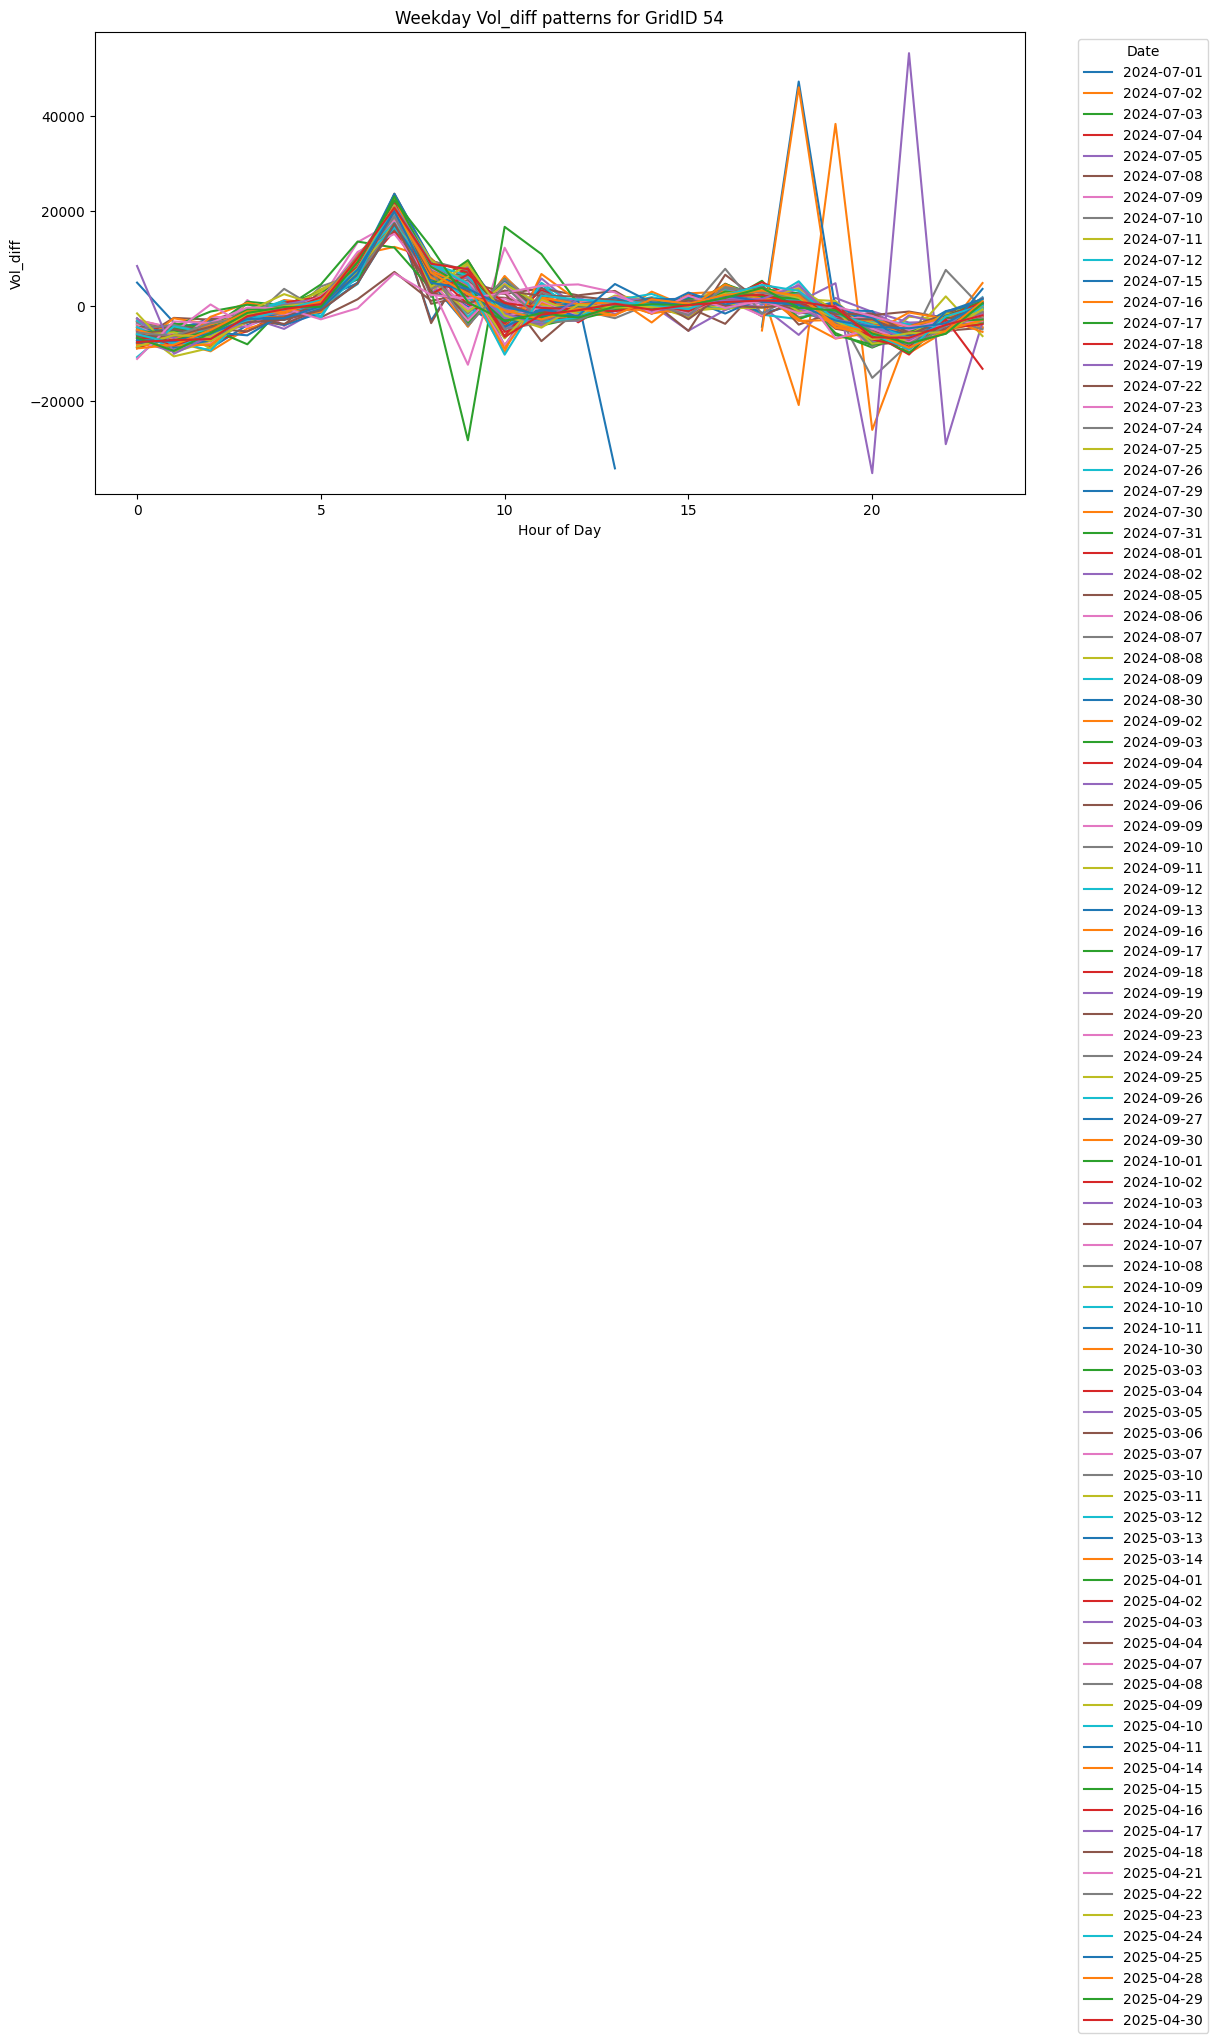

In [ ]:

df_weekdays['date'] = df_weekdays['End_Time'].dt.date
df_weekdays['hour'] = df_weekdays['End_Time'].dt.hour  # or use End_Time directly if hourly

# Plot each day on the same graph
plt.figure(figsize=(12,6))
for date, group in df_weekdays.groupby('date'):
    plt.plot(group['hour'], group['Vol_diff'], label=str(date))

plt.xlabel("Hour of Day")
plt.ylabel("Vol_diff")
plt.title(f"Weekday Vol_diff patterns for GridID {grid_id}")
#plt.legend(title="Date", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [226]:

integrals = {}

for date, group in df_weekdays.groupby('date'):
    # Make sure values are sorted in time
    group = group.sort_values('End_Time')
    
    # x = time in hours since start of the day
    x = (group['End_Time'] - group['End_Time'].min()).dt.total_seconds() / 3600
    y = group['Vol_diff'].values
    
    # Trapezoidal integration
    integral = np.trapz(y, x)
    integrals[date] = integral

# Convert to DataFrame
daily_integrals = pd.DataFrame(list(integrals.items()), columns=['date', 'integral'])
print(daily_integrals)


          date  integral
0   2024-07-01      27.5
1   2024-07-02    5299.0
2   2024-07-03    6813.0
3   2024-07-04    3125.5
4   2024-07-05    4030.5
..         ...       ...
89  2025-04-24    8230.5
90  2025-04-25    4634.5
91  2025-04-28    3147.0
92  2025-04-29    4016.5
93  2025-04-30    3563.0

[94 rows x 2 columns]


C:\Users\user1\AppData\Local\Temp\ipykernel_10676\3977370359.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral = np.trapz(y, x)


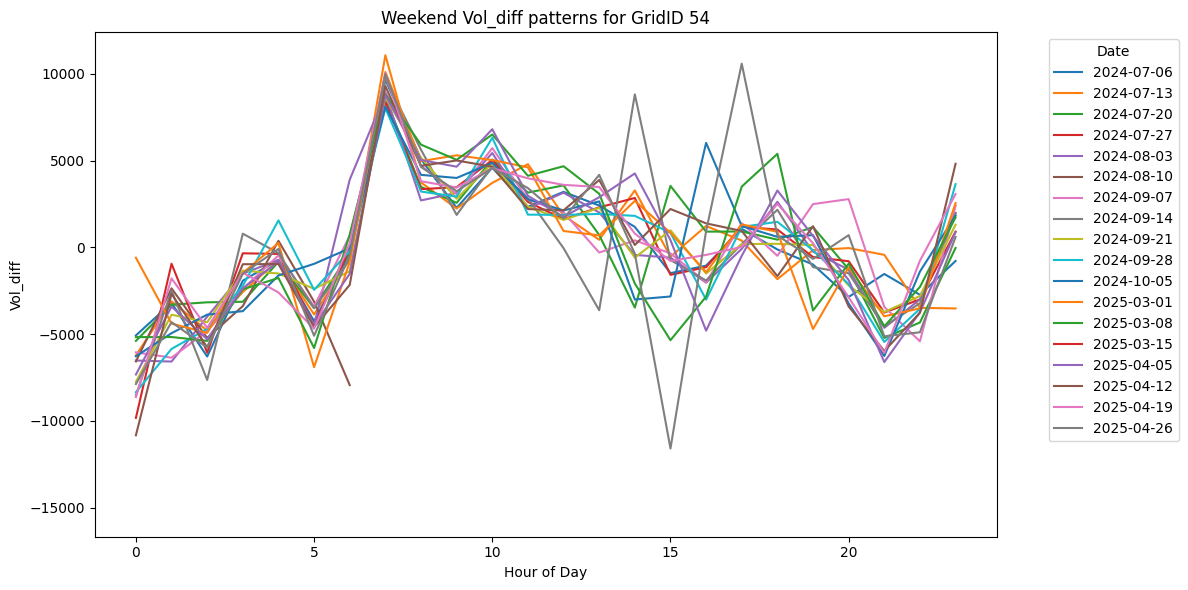

In [227]:

df_sat['date'] = df_sat['End_Time'].dt.date
df_sat['hour'] = df_sat['End_Time'].dt.hour  # or use End_Time directly if hourly

# Plot each day on the same graph
plt.figure(figsize=(12,6))
for date, group in df_sat.groupby('date'):
    plt.plot(group['hour'], group['Vol_diff'], label=str(date))

plt.xlabel("Hour of Day")
plt.ylabel("Vol_diff")
plt.title(f"Weekend Vol_diff patterns for GridID {grid_id}")
plt.legend(title="Date", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [228]:
integrals_sat = {}

for date, group in df_sat.groupby('date'):
    # Make sure values are sorted in time
    group = group.sort_values('End_Time')
    
    # x = time in hours since start of the day
    x = (group['End_Time'] - group['End_Time'].min()).dt.total_seconds() / 3600
    y = group['Vol_diff'].values
    
    # Trapezoidal integration
    integral = np.trapz(y, x)
    integrals_sat[date] = integral

# Convert to DataFrame
daily_integrals_sat = pd.DataFrame(list(integrals_sat.items()), columns=['date', 'integral'])
print(daily_integrals_sat)

          date  integral
0   2024-07-06    1425.5
1   2024-07-13    5696.0
2   2024-07-20    2968.5
3   2024-07-27    4352.0
4   2024-08-03    2228.0
5   2024-08-10  -20962.0
6   2024-09-07    3796.5
7   2024-09-14    2079.5
8   2024-09-21     395.0
9   2024-09-28    1044.5
10  2024-10-05    3282.5
11  2025-03-01    5378.5
12  2025-03-08    3947.0
13  2025-03-15       0.0
14  2025-04-05    2919.5
15  2025-04-12    2883.0
16  2025-04-19    7887.0
17  2025-04-26    1137.0


C:\Users\user1\AppData\Local\Temp\ipykernel_10676\1937423952.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral = np.trapz(y, x)


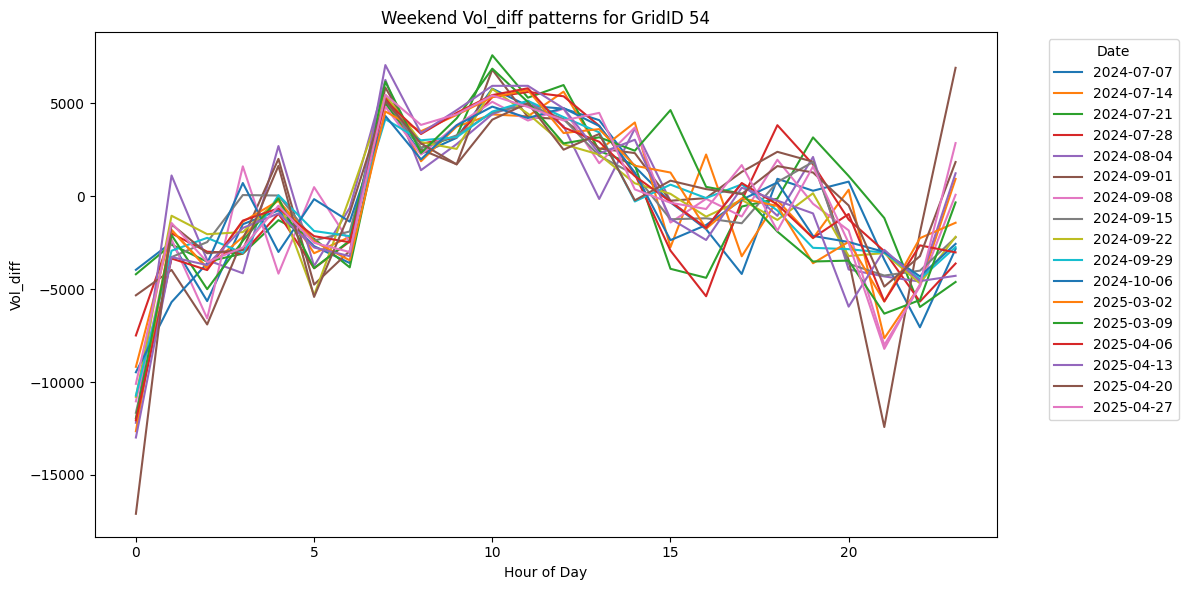

In [229]:

df_sun['date'] = df_sun['End_Time'].dt.date
df_sun['hour'] = df_sun['End_Time'].dt.hour  # or use End_Time directly if hourly

# Plot each day on the same graph
plt.figure(figsize=(12,6))
for date, group in df_sun.groupby('date'):
    plt.plot(group['hour'], group['Vol_diff'], label=str(date))

plt.xlabel("Hour of Day")
plt.ylabel("Vol_diff")
plt.title(f"Weekend Vol_diff patterns for GridID {grid_id}")
plt.legend(title="Date", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [230]:
integrals_sun = {}

for date, group in df_sun.groupby('date'):
    # Make sure values are sorted in time
    group = group.sort_values('End_Time')
    
    # x = time in hours since start of the day
    x = (group['End_Time'] - group['End_Time'].min()).dt.total_seconds() / 3600
    y = group['Vol_diff'].values
    
    # Trapezoidal integration
    integral = np.trapz(y, x)
    integrals_sun[date] = integral

# Convert to DataFrame
daily_integrals_sun = pd.DataFrame(list(integrals_sun.items()), columns=['date', 'integral'])
print(daily_integrals_sun)

          date  integral
0   2024-07-07   -3157.0
1   2024-07-14   -3773.5
2   2024-07-21    1045.0
3   2024-07-28   -1007.5
4   2024-08-04     697.0
5   2024-09-01    -354.5
6   2024-09-08   -4363.0
7   2024-09-15   -1983.5
8   2024-09-22   -3331.0
9   2024-09-29   -4089.5
10  2024-10-06   -5334.0
11  2025-03-02   -3072.5
12  2025-03-09   -4308.5
13  2025-04-06   -2588.0
14  2025-04-13   -4722.5
15  2025-04-20     468.0
16  2025-04-27     519.5


C:\Users\user1\AppData\Local\Temp\ipykernel_10676\1795947066.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral = np.trapz(y, x)


In [231]:
def fit_fourier(df, n_harmonics):
    """
    Fit Fourier series to Vol_diff as a function of hour-of-day.
    Returns model and dataframe with fitted curve.
    """
    # Ensure datetime
    df['End_Time'] = pd.to_datetime(df['End_Time'])
    df['hour'] = df['End_Time'].dt.hour
    
    # Collapse by average per hour (so all days align)
    hourly = df.groupby('hour')['Vol_diff'].mean().reset_index()
    X = []
    
    for k in range(1, n_harmonics+1):
        hourly[f'sin{k}'] = np.sin(2*np.pi*k*hourly['hour']/24)
        hourly[f'cos{k}'] = np.cos(2*np.pi*k*hourly['hour']/24)
        X.append(hourly[[f'sin{k}', f'cos{k}']])
    
    X = pd.concat(X, axis=1)
    
    # Fit regression
    model = LinearRegression()
    model.fit(X, hourly['Vol_diff'])
    
    # Predict smooth curve
    hours = np.linspace(0, 23, 200)
    X_pred = []
    for k in range(1, n_harmonics+1):
        X_pred.append(pd.DataFrame({
            f'sin{k}': np.sin(2*np.pi*k*hours/24),
            f'cos{k}': np.cos(2*np.pi*k*hours/24)
        }))
    X_pred = pd.concat(X_pred, axis=1)
    y_pred = model.predict(X_pred)
    
    return hourly, hours, y_pred, model

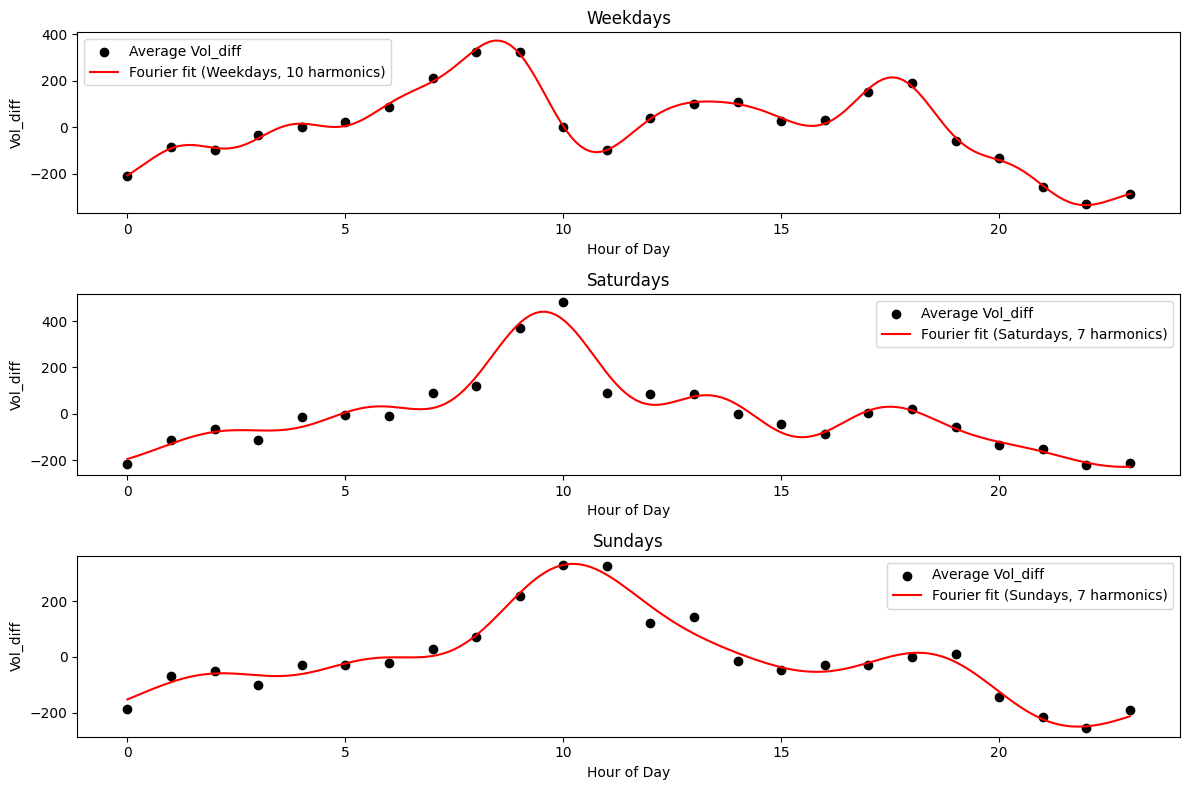

In [269]:
# Store results here
results = {}

groups = {
    "Weekdays": df_weekdays,
    "Saturdays": df_sat,
    "Sundays": df_sun
}

# Define harmonics per group
harmonics_map = {
    "Weekdays": 10,
    "Saturdays": 7,
    "Sundays": 7
}

plt.figure(figsize=(12, 8))

for i, (label, df) in enumerate(groups.items(), 1):
    n_harmonics = harmonics_map[label]   # choose harmonics by group
    hourly, hours, y_pred, model = fit_fourier(df, n_harmonics=n_harmonics)

    # Save results
    results[label] = {
        "hourly": hourly,
        "hours": hours,
        "y_pred": y_pred,
        "model": model,
        "n_harmonics": n_harmonics
    }

    # Plot
    plt.subplot(3, 1, i)
    plt.scatter(hourly['hour'], hourly['Vol_diff'], label="Average Vol_diff", color="black")
    plt.plot(hours, y_pred, label=f"Fourier fit ({label}, {n_harmonics} harmonics)", color="red")
    plt.title(label)
    plt.xlabel("Hour of Day")
    plt.ylabel("Vol_diff")
    plt.legend()

plt.tight_layout()
plt.show()

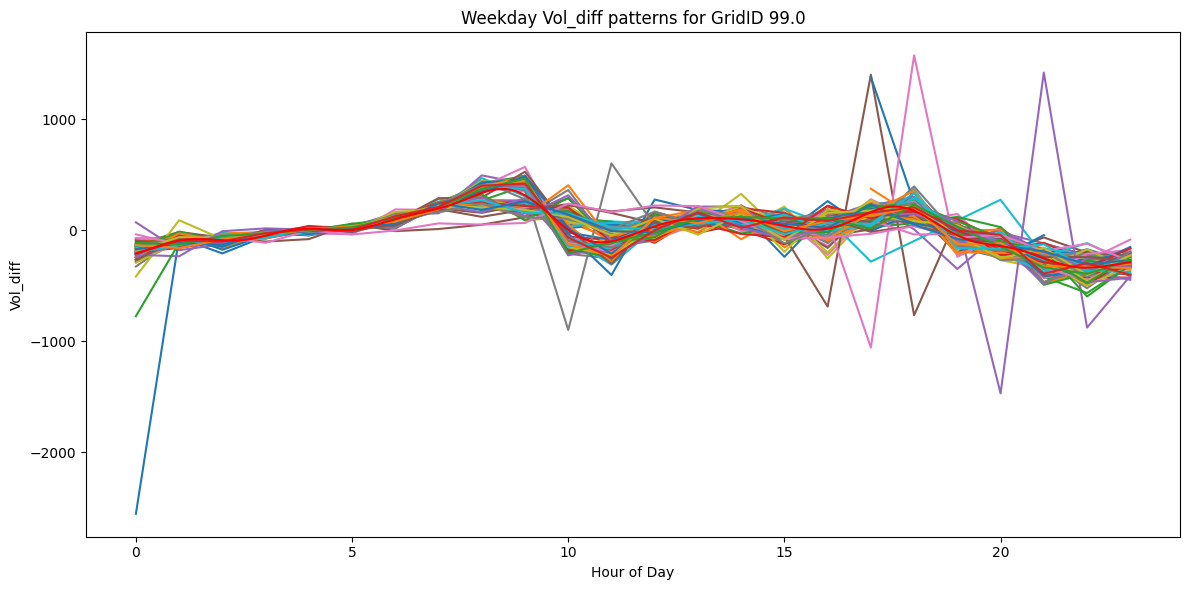

In [270]:
df_weekdays['date'] = df_weekdays['End_Time'].dt.date
df_weekdays['hour'] = df_weekdays['End_Time'].dt.hour  # or use End_Time directly if hourly

# Plot each day on the same graph
plt.figure(figsize=(12,6))
for date, group in df_weekdays.groupby('date'):
    plt.plot(group['hour'], group['Vol_diff'], label=str(date))

plt.plot(results['Weekdays']['hours'], results['Weekdays']['y_pred'], label=f"Fourier fit ({label})", color="red")

plt.xlabel("Hour of Day")
plt.ylabel("Vol_diff")
plt.title(f"Weekday Vol_diff patterns for GridID {grid_id}")
#plt.legend(title="Date", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
#edit

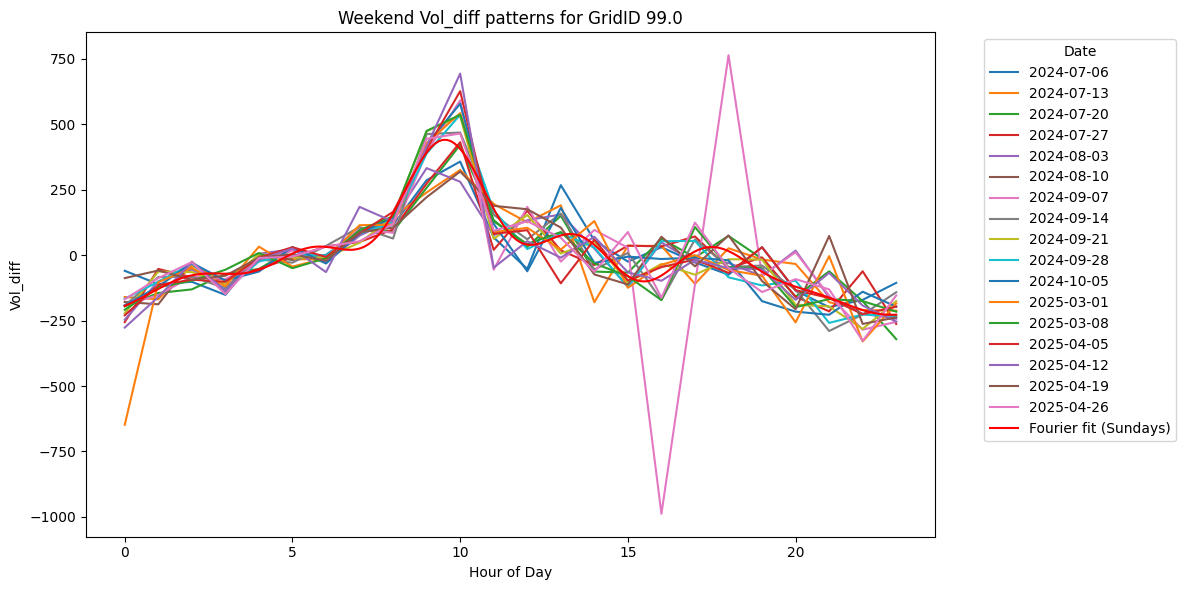

In [271]:
df_sat['date'] = df_sat['End_Time'].dt.date
df_sat['hour'] = df_sat['End_Time'].dt.hour  # or use End_Time directly if hourly

# Plot each day on the same graph
plt.figure(figsize=(12,6))
for date, group in df_sat.groupby('date'):
    plt.plot(group['hour'], group['Vol_diff'], label=str(date))

plt.plot(results['Saturdays']['hours'], results['Saturdays']['y_pred'], label=f"Fourier fit ({label})", color="red")

plt.xlabel("Hour of Day")
plt.ylabel("Vol_diff")
plt.title(f"Weekend Vol_diff patterns for GridID {grid_id}")
plt.legend(title="Date", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

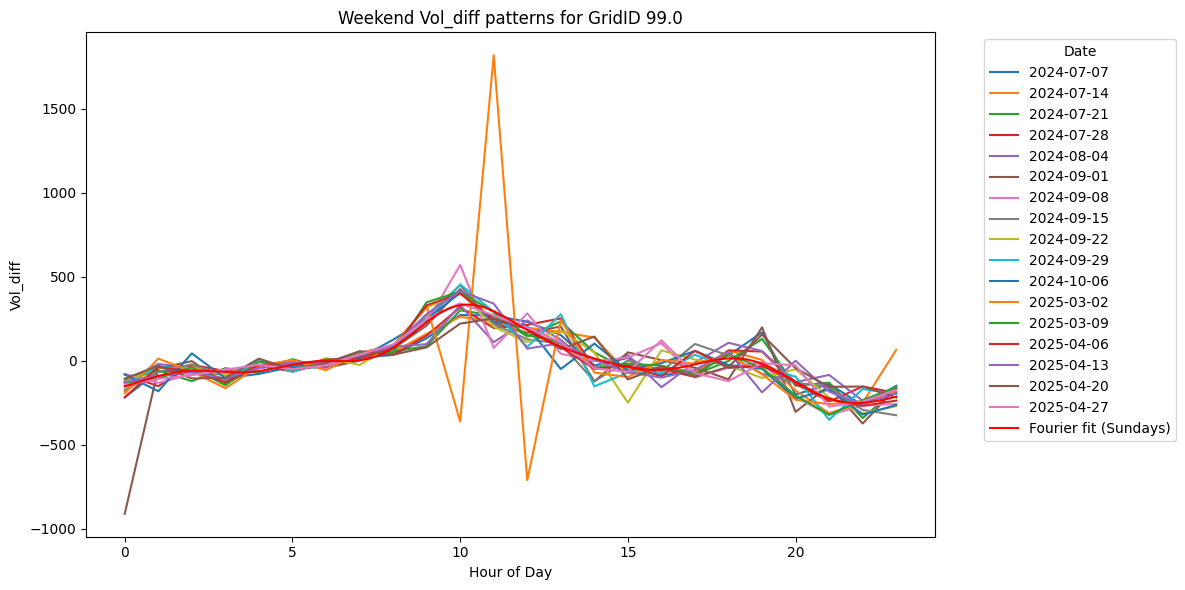

In [272]:

df_sun['date'] = df_sun['End_Time'].dt.date
df_sun['hour'] = df_sun['End_Time'].dt.hour  # or use End_Time directly if hourly

# Plot each day on the same graph
plt.figure(figsize=(12,6))
for date, group in df_sun.groupby('date'):
    plt.plot(group['hour'], group['Vol_diff'], label=str(date))

plt.plot(results['Sundays']['hours'], results['Sundays']['y_pred'], label=f"Fourier fit ({label})", color="red")

plt.xlabel("Hour of Day")
plt.ylabel("Vol_diff")
plt.title(f"Weekend Vol_diff patterns for GridID {grid_id}")
plt.legend(title="Date", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [306]:
# Dictionary to hold Fourier fit results
all_results = {}

# Collect mean reversion stats in a list
records = []

# Loop over every Grid_ID
for grid_id in joined_eval["Grid_ID"].unique():
    # Split this grid's data into weekdays, Saturday, Sunday
    df_weekdays = weekdays[weekdays["Grid_ID"] == grid_id].copy()
    df_sat = saturdays[saturdays["Grid_ID"] == grid_id].copy()
    df_sun = sundays[sundays["Grid_ID"] == grid_id].copy()

    # Skip if grid has no data at all
    if df_weekdays.empty and df_sat.empty and df_sun.empty:
        continue

    # Organize groups
    groups = {
        "Weekdays": df_weekdays,
        "Saturdays": df_sat,
        "Sundays": df_sun
    }

    # Choose harmonics per group
    harmonics_map = {
        "Weekdays": 14,
        "Saturdays": 10,
        "Sundays": 10
    }

    grid_results = {}

    # Fit and save Fourier models for each group
    for label, df in groups.items():
        if df.empty:
            continue  # skip missing groups

        n_harmonics = harmonics_map[label]
        hourly, hours, y_pred, model = fit_fourier(df, n_harmonics=n_harmonics)

        # Save fits in all_results
        grid_results[label] = {
            "hourly": hourly,
            "hours": hours,
            "y_pred": y_pred,
            "model": model,
            "n_harmonics": n_harmonics
        }

        # --- Mean reversion stats ---
        df = df.copy()
        df["hour"] = pd.to_datetime(df["End_Time"]).dt.hour

        # Build design matrix for raw df
        X = []
        for k in range(1, n_harmonics+1):
            X.append(pd.DataFrame({
                f'sin{k}': np.sin(2*np.pi*k*df['hour']/24),
                f'cos{k}': np.cos(2*np.pi*k*df['hour']/24)
            }))
        X = pd.concat(X, axis=1)

        df["fitted"] = model.predict(X)
        df["residuals"] = df["Vol_diff"] - df["fitted"]
        residuals = df["residuals"].values

        # ADF test
        try:
            adf_stat, p_val, *_ = adfuller(residuals)
        except Exception:
            adf_stat, p_val = None, None

        # AR(1) beta
        if len(residuals) > 1:
            r, r_next = residuals[:-1], residuals[1:]
            ar1_model = sm.OLS(r_next, sm.add_constant(r)).fit()
            beta = ar1_model.params[1]
        else:
            beta = None

        records.append({
            "Grid_ID": grid_id,
            "Group": label,
            "ADF_stat": adf_stat,
            "ADF_pval": p_val,
            "AR1_beta": beta
        })

    # Save all group results under this Grid_ID
    all_results[grid_id] = grid_results

# Convert mean reversion stats to dataframe
MeanReversionStats = pd.DataFrame(records)

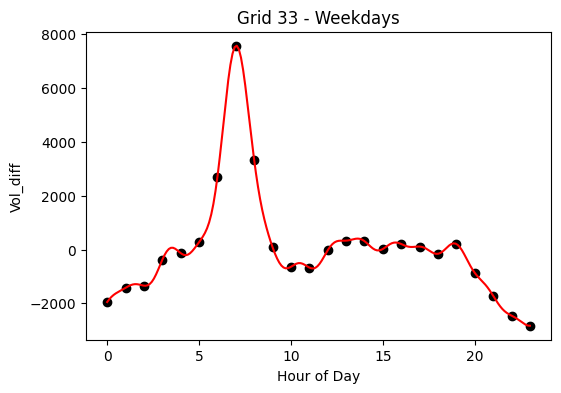

In [339]:

Grid = 33
gridxx_weekdays = all_results[Grid]["Weekdays"]

plt.figure(figsize=(6,4))
plt.scatter(gridxx_weekdays["hourly"]['hour'], gridxx_weekdays["hourly"]['Vol_diff'], color="black")
plt.plot(gridxx_weekdays["hours"], gridxx_weekdays["y_pred"], color="red")
plt.title(f"Grid {Grid} - Weekdays")
plt.xlabel("Hour of Day")
plt.ylabel("Vol_diff")
plt.show()


In [308]:
records = []

# Loop through all results
for grid_id, grid_results in all_results.items():
    for label, res in grid_results.items():
        hours = res["hours"]
        y_pred = res["y_pred"]
        area = trapz(y_pred, hours)

        records.append({
            "Grid_ID": grid_id,
            "Group": label,
            "Integral": area
        })

# Convert to dataframe
Fit_Integrals = pd.DataFrame(records)

C:\Users\user1\AppData\Local\Temp\ipykernel_10676\1076102971.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = trapz(y_pred, hours)


In [309]:
Fit_Integrals

,Grid_ID,Group,Integral
0,3.0,Weekdays,622.829167
1,3.0,Saturdays,191.235200
2,3.0,Sundays,48.279753
3,4.0,Weekdays,665.588428
4,4.0,Saturdays,248.181030
...,...,...,...
205,98.0,Saturdays,464.446041
206,98.0,Sundays,116.630818
207,99.0,Weekdays,271.168796
208,99.0,Saturdays,124.497343


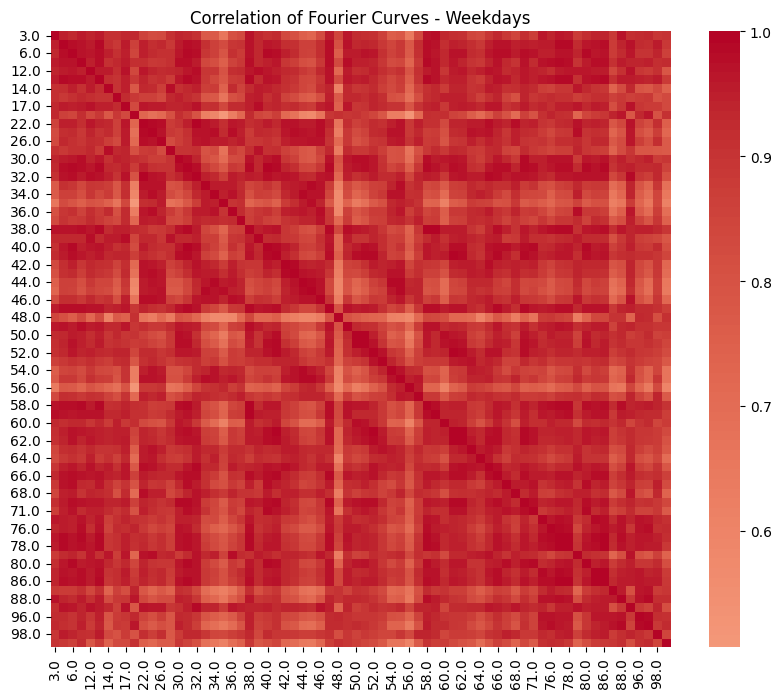

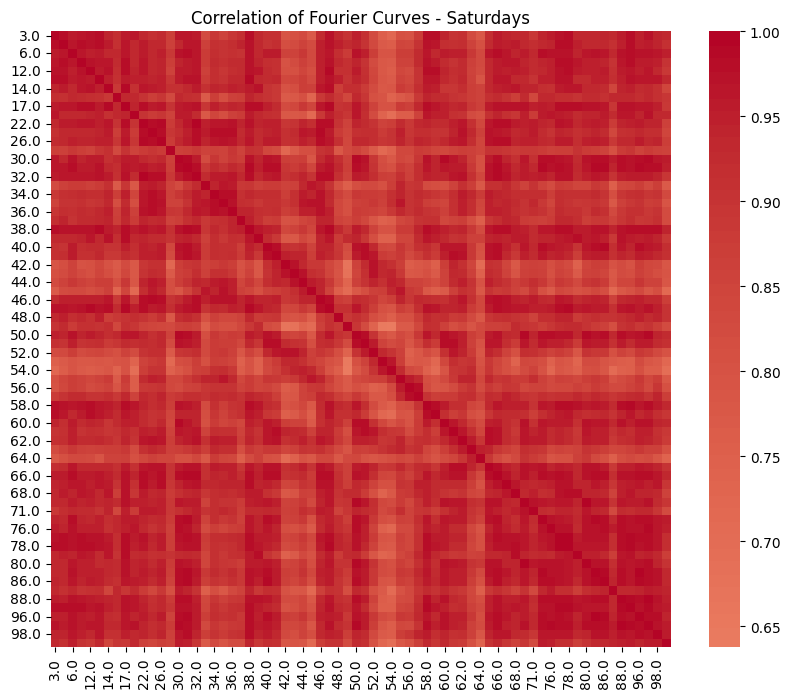

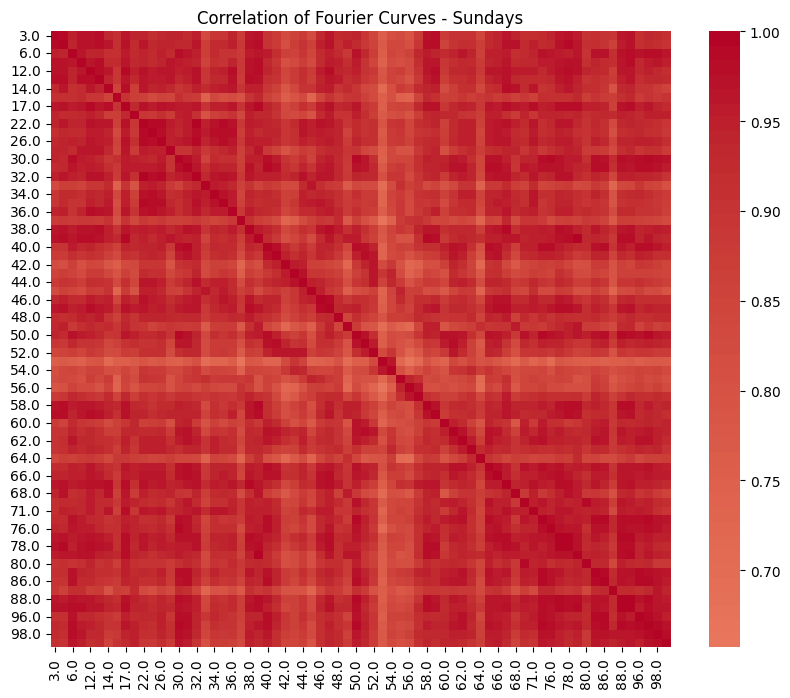

In [310]:
reference_hours = next(iter(next(iter(all_results.values())).values()))["hours"]

for group in ["Weekdays", "Saturdays", "Sundays"]:
    curves = {}

    # Collect fitted curves for each grid
    for grid_id, grid_results in all_results.items():
        if group in grid_results:
            res = grid_results[group]
            # y_pred should already be aligned with hours
            curves[grid_id] = res["y_pred"]

    # Build DataFrame: each column = grid_id, each row = predicted value at given hour
    df_curves = pd.DataFrame(curves, index=reference_hours)

    # Correlation across Grid_IDs
    corr = df_curves.corr()

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, cmap="coolwarm", center=0)
    plt.title(f"Correlation of Fourier Curves - {group}")
    plt.show()

In [311]:
MeanReversionStats

,Grid_ID,Group,ADF_stat,ADF_pval,AR1_beta
0,3.0,Weekdays,-12.212663,1.154282e-22,0.019781
1,3.0,Saturdays,-7.786832,8.137476e-12,-0.169972
2,3.0,Sundays,-8.624387,5.984896e-14,-0.192859
3,4.0,Weekdays,-10.064180,1.309469e-17,-0.109537
4,4.0,Saturdays,-8.961017,8.224356e-15,-0.137319
...,...,...,...,...,...
205,98.0,Saturdays,-14.097821,2.651114e-26,-0.044021
206,98.0,Sundays,-17.209280,6.384487e-30,-0.261787
207,99.0,Weekdays,-10.637358,5.032152e-19,-0.283799
208,99.0,Saturdays,-9.803368,5.913757e-17,-0.346834


In [312]:
print("ADF_pval summary:")
print(MeanReversionStats["ADF_pval"].describe())

print("\nAR1_beta summary:")
print(MeanReversionStats["AR1_beta"].describe())

ADF_pval summary:
count    2.100000e+02
mean     5.944549e-08
std      8.505106e-07
min      0.000000e+00
25%      2.140569e-25
50%      5.384247e-21
75%      7.592274e-17
max      1.232540e-05
Name: ADF_pval, dtype: float64

AR1_beta summary:
count    210.000000
mean      -0.203128
std        0.142451
min       -0.589803
25%       -0.296882
50%       -0.191448
75%       -0.096302
max        0.111598
Name: AR1_beta, dtype: float64


In [313]:
may_groups = {
    "Weekdays": may_weekdays,
    "Saturdays": may_saturdays,
    "Sundays": may_sundays
}

may_records = []

for grid_id, grid_results in all_results.items():
    for label, res in grid_results.items():
        # Grab May data for this group
        if label not in may_groups:
            continue
        df = may_groups[label]
        df = df[df["Grid_ID"] == grid_id].copy()
        if df.empty:
            continue

        n_harmonics = res["n_harmonics"]
        model = res["model"]

        # Build Fourier features for May data
        df["hour"] = pd.to_datetime(df["End_Time"]).dt.hour
        X_may = []
        for k in range(1, n_harmonics+1):
            X_may.append(pd.DataFrame({
                f'sin{k}': np.sin(2*np.pi*k*df['hour']/24),
                f'cos{k}': np.cos(2*np.pi*k*df['hour']/24)
            }))
        X_may = pd.concat(X_may, axis=1)

        # Predict
        df["fitted"] = model.predict(X_may)

        # Store metrics
        mse = mean_squared_error(df["Vol_diff"], df["fitted"])
        r2 = r2_score(df["Vol_diff"], df["fitted"])

        may_records.append({
            "Grid_ID": grid_id,
            "Group": label,
            "RMSE": np.sqrt(mse),
            "R2": r2
        })

MayFitStats = pd.DataFrame(may_records)


In [314]:
MayFitStats

,Grid_ID,Group,RMSE,R2
0,3.0,Weekdays,222.512842,0.791628
1,3.0,Saturdays,150.980977,0.836618
2,3.0,Sundays,143.847448,0.787168
3,4.0,Weekdays,236.295661,0.708030
4,4.0,Saturdays,172.610064,0.745673
...,...,...,...,...
205,98.0,Saturdays,303.989766,0.802068
206,98.0,Sundays,236.564543,0.862401
207,99.0,Weekdays,117.472513,0.713568
208,99.0,Saturdays,156.116526,0.512894


In [315]:
print("=== May RMSE summary by Group ===")
print(MayFitStats.groupby("Group")["RMSE"].describe(), "\n")

print("=== May R2 summary by Group ===")
print(MayFitStats.groupby("Group")["R2"].describe())

=== May RMSE summary by Group ===
           count        mean         std        min         25%         50%  \
Group                                                                         
Saturdays   70.0  506.708966  429.352849  30.089767  218.385612  385.493388   
Sundays     70.0  414.225409  351.832808  25.504034  200.873941  305.689376   
Weekdays    70.0  552.174883  486.927703  80.954337  284.564873  416.228488   

                  75%          max  
Group                               
Saturdays  640.250150  1974.418830  
Sundays    493.565041  1723.606866  
Weekdays   624.653496  2860.807220   

=== May R2 summary by Group ===
           count      mean       std       min       25%       50%       75%  \
Group                                                                          
Saturdays   70.0  0.749786  0.145710  0.221150  0.672250  0.802463  0.854879   
Sundays     70.0  0.790041  0.140189  0.150138  0.776203  0.834856  0.874315   
Weekdays    70.0  0.811237  0.1

In [316]:
reversion_records = []

for grid_id, grid_results in all_results.items():
    for label, res in grid_results.items():
        # Grab May data for this group
        if label not in may_groups:
            continue
        df = may_groups[label]
        df = df[df["Grid_ID"] == grid_id].copy()
        if df.empty:
            continue

        n_harmonics = res["n_harmonics"]
        model = res["model"]

        # Build Fourier features for May data
        df["hour"] = pd.to_datetime(df["End_Time"]).dt.hour
        X_may = []
        for k in range(1, n_harmonics+1):
            X_may.append(pd.DataFrame({
                f'sin{k}': np.sin(2*np.pi*k*df['hour']/24),
                f'cos{k}': np.cos(2*np.pi*k*df['hour']/24)
            }))
        X_may = pd.concat(X_may, axis=1)

        # Residuals (May data vs old Fourier fit)
        df["fitted"] = model.predict(X_may)
        df["residuals"] = df["Vol_diff"] - df["fitted"]
        residuals = df["residuals"].values

        # --- Mean reversion tests ---
        try:
            adf_stat, p_value, *_ = adfuller(residuals)
        except Exception:
            adf_stat, p_value = None, None

        if len(residuals) > 1:
            r, r_next = residuals[:-1], residuals[1:]
            ar1_model = sm.OLS(r_next, sm.add_constant(r)).fit()
            beta = ar1_model.params[1]
        else:
            beta = None

        reversion_records.append({
            "Grid_ID": grid_id,
            "Group": label,
            "ADF_stat": adf_stat,
            "ADF_pval": p_value,
            "AR1_beta": beta
        })

# Collect results
MayMeanReversionStats = pd.DataFrame(reversion_records)

In [317]:
MayMeanReversionStats

,Grid_ID,Group,ADF_stat,ADF_pval,AR1_beta
0,3.0,Weekdays,-8.598860,6.956820e-14,0.076363
1,3.0,Saturdays,-11.029862,5.704125e-20,-0.026815
2,3.0,Sundays,-11.918683,5.092732e-22,-0.222568
3,4.0,Weekdays,-9.887815,3.624487e-17,-0.041695
4,4.0,Saturdays,-4.976484,2.469852e-05,0.206117
...,...,...,...,...,...
205,98.0,Saturdays,-7.552881,3.154687e-11,-0.069801
206,98.0,Sundays,-9.780169,6.766570e-17,-0.013855
207,99.0,Weekdays,-12.194600,1.262976e-22,-0.096798
208,99.0,Saturdays,-10.180274,6.723342e-18,-0.438284


In [318]:
print("ADF_pval summary:")
print(MayMeanReversionStats["ADF_pval"].describe())

print("\nAR1_beta summary:")
print(MayMeanReversionStats["AR1_beta"].describe())

ADF_pval summary:
count    2.100000e+02
mean     2.279385e-03
std      2.063989e-02
min      1.109351e-29
25%      1.204676e-21
50%      9.478857e-16
75%      2.033118e-10
max      2.745536e-01
Name: ADF_pval, dtype: float64

AR1_beta summary:
count    210.000000
mean      -0.184483
std        0.183428
min       -0.598968
25%       -0.319316
50%       -0.195826
75%       -0.042086
max        0.233532
Name: AR1_beta, dtype: float64


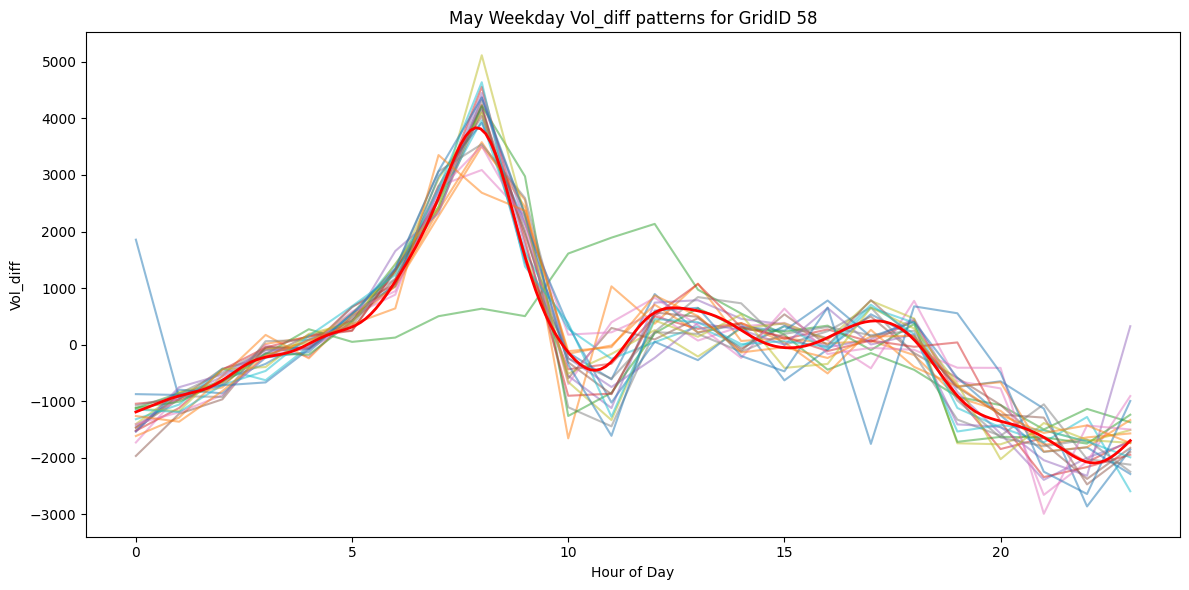

In [319]:
grid_id=58
label = "Weekdays"

# Get May weekday data for this grid
df_may_weekdays = may_weekdays[may_weekdays["Grid_ID"] == grid_id].copy()
df_may_weekdays["date"] = pd.to_datetime(df_may_weekdays["End_Time"]).dt.date
df_may_weekdays["hour"] = pd.to_datetime(df_may_weekdays["End_Time"]).dt.hour

plt.figure(figsize=(12,6))

# Plot each May weekday separately
for date, group in df_may_weekdays.groupby("date"):
    plt.plot(group["hour"], group["Vol_diff"], alpha=0.5, label=str(date))

# Overlay Fourier best fit from earlier training
res = all_results[grid_id][label]
plt.plot(res["hours"], res["y_pred"], color="red", linewidth=2, label="Fourier Fit (Weekdays)")

plt.xlabel("Hour of Day")
plt.ylabel("Vol_diff")
plt.title(f"May Weekday Vol_diff patterns for GridID {grid_id}")
# plt.legend(title="Date", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

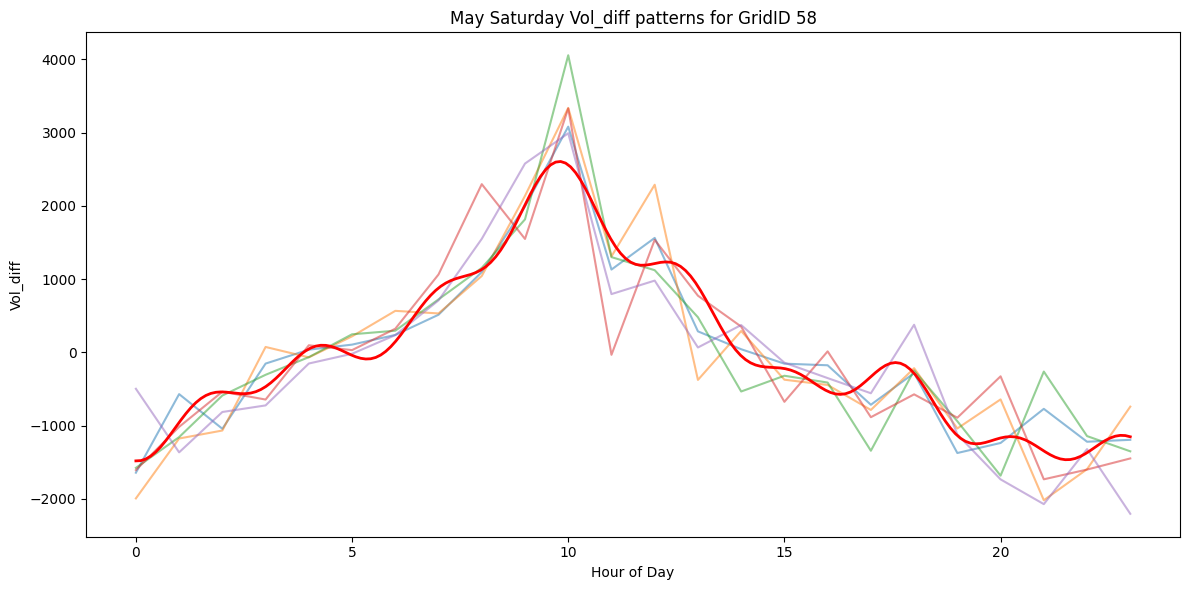

In [320]:
label = "Saturdays"

# Get May Saturday data for this grid
df_may_sat = may_saturdays[may_saturdays["Grid_ID"] == grid_id].copy()
df_may_sat["date"] = pd.to_datetime(df_may_sat["End_Time"]).dt.date
df_may_sat["hour"] = pd.to_datetime(df_may_sat["End_Time"]).dt.hour

plt.figure(figsize=(12,6))

# Plot each May Saturday separately
for date, group in df_may_sat.groupby("date"):
    plt.plot(group["hour"], group["Vol_diff"], alpha=0.5, label=str(date))

# Overlay Fourier best fit from earlier training
res = all_results[grid_id][label]
plt.plot(res["hours"], res["y_pred"], color="red", linewidth=2, label="Fourier Fit (Saturdays)")

plt.xlabel("Hour of Day")
plt.ylabel("Vol_diff")
plt.title(f"May Saturday Vol_diff patterns for GridID {grid_id}")
# plt.legend(title="Date", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

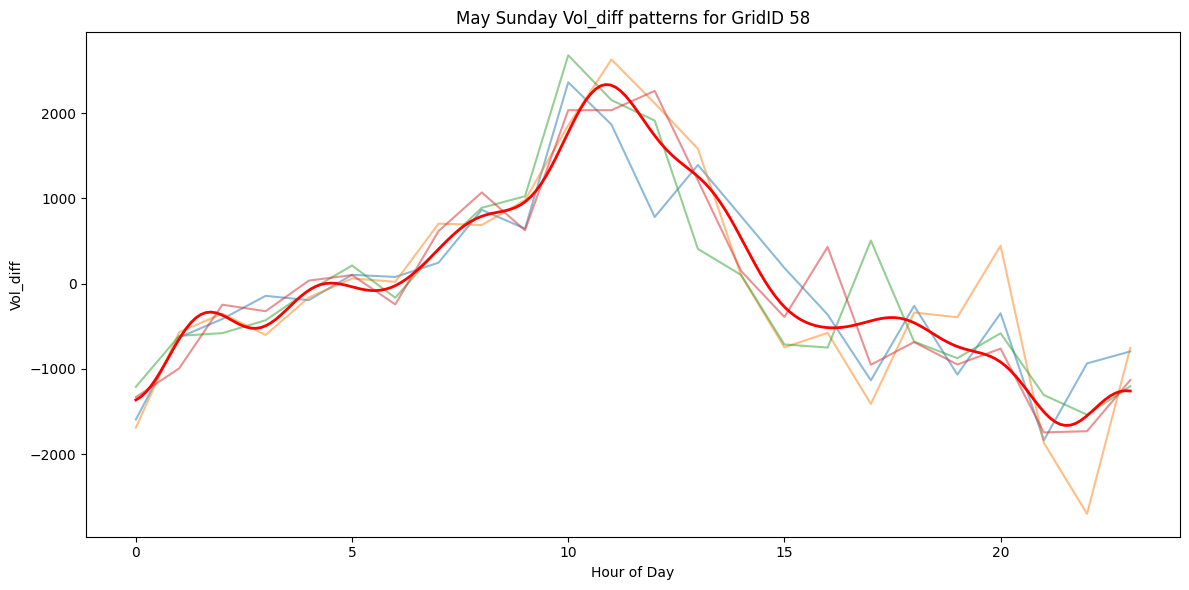

In [321]:
label = "Sundays"

# Get May Sunday data for this grid
df_may_sun = may_sundays[may_sundays["Grid_ID"] == grid_id].copy()
df_may_sun["date"] = pd.to_datetime(df_may_sun["End_Time"]).dt.date
df_may_sun["hour"] = pd.to_datetime(df_may_sun["End_Time"]).dt.hour

plt.figure(figsize=(12,6))

# Plot each May Sunday separately
for date, group in df_may_sun.groupby("date"):
    plt.plot(group["hour"], group["Vol_diff"], alpha=0.5, label=str(date))

# Overlay Fourier best fit from earlier training
res = all_results[grid_id][label]
plt.plot(res["hours"], res["y_pred"], color="red", linewidth=2, label="Fourier Fit (Sundays)")

plt.xlabel("Hour of Day")
plt.ylabel("Vol_diff")
plt.title(f"May Sunday Vol_diff patterns for GridID {grid_id}")
# plt.legend(title="Date", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [322]:
def forecast_with_mean_reversion(df, model, n_harmonics, cutoff_hour):
    df = df.copy()
    df["hour"] = pd.to_datetime(df["End_Time"]).dt.hour

    # Build Fourier features
    X_all = []
    for k in range(1, n_harmonics+1):
        X_all.append(pd.DataFrame({
            f'sin{k}': np.sin(2*np.pi*k*df['hour']/24),
            f'cos{k}': np.cos(2*np.pi*k*df['hour']/24)
        }))
    X_all = pd.concat(X_all, axis=1)

    df["fitted"] = model.predict(X_all)
    df["residuals"] = df["Vol_diff"] - df["fitted"]

    # Split early vs late
    df_early = df[df["hour"] <= cutoff_hour]
    df_late = df[df["hour"] > cutoff_hour]

    if df_early.empty or df_late.empty or len(df_early) < 2:
        return df_early, df_late, None, None   # <-- always 4 outputs

    # Fit AR(1) on early residuals
    r = df_early["residuals"].values
    r_lag, r_next = r[:-1], r[1:]
    ar1_model = sm.OLS(r_next, sm.add_constant(r_lag)).fit()

    # Forecast residual path for late hours
    last_resid = r[-1]
    forecast_resids = []
    for _ in range(len(df_late)):
        last_resid = ar1_model.params[0] + ar1_model.params[1]*last_resid
        forecast_resids.append(last_resid)

    df_late["adjusted_pred"] = df_late["fitted"].values + np.array(forecast_resids)

    # Metrics for late part only
    rmse = np.sqrt(mean_squared_error(df_late["Vol_diff"], df_late["adjusted_pred"]))
    r2 = r2_score(df_late["Vol_diff"], df_late["adjusted_pred"])

    return df_early, df_late, rmse, r2 


In [323]:
comp_records = []
may_groups = {
    "Weekdays": may_weekdays,
    "Saturdays": may_saturdays,
    "Sundays": may_sundays
}

for grid_id, grid_results in all_results.items():
    for label, res in grid_results.items():
        if label not in may_groups:
            continue
        df = may_groups[label]
        df = df[df["Grid_ID"] == grid_id].copy()
        if df.empty:
            continue

        _, _, rmse, r2 = forecast_with_mean_reversion(
            df=df,
            model=res["model"],
            n_harmonics=res["n_harmonics"],
            cutoff_hour=12   # can change cutoff
        )

        if rmse is not None:
            comp_records.append({
                "Grid_ID": grid_id,
                "Group": label,
                "CutoffHour": 12,
                "RMSE": rmse,
                "R2": r2
            })

MayMeanReversionFitStats = pd.DataFrame(comp_records)

C:\Users\user1\AppData\Local\Temp\ipykernel_10676\2912442766.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_late["adjusted_pred"] = df_late["fitted"].values + np.array(forecast_resids)
C:\Users\user1\AppData\Local\Temp\ipykernel_10676\2912442766.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_late["adjusted_pred"] = df_late["fitted"].values + np.array(forecast_resids)
C:\Users\user1\AppData\Local\Temp\ipykernel_10676\2912442766.py:36: SettingWithCopyWarning: 
A value is trying to be set on 

In [324]:
MayMeanReversionFitStats

,Grid_ID,Group,CutoffHour,RMSE,R2
0,3.0,Weekdays,12,267.913723,0.640844
1,3.0,Saturdays,12,177.264891,0.321676
2,3.0,Sundays,12,192.346161,0.445937
3,4.0,Weekdays,12,272.527579,0.346804
4,4.0,Saturdays,12,213.532107,0.048200
...,...,...,...,...,...
205,98.0,Saturdays,12,376.077427,0.343769
206,98.0,Sundays,12,270.168935,0.628940
207,99.0,Weekdays,12,118.554537,0.682049
208,99.0,Saturdays,12,107.456813,0.373243


In [325]:
print("=== May RMSE summary by Group ===")
print(MayMeanReversionFitStats.groupby("Group")["RMSE"].describe(), "\n")

print("=== May R2 summary by Group ===")
print(MayMeanReversionFitStats.groupby("Group")["R2"].describe())

=== May RMSE summary by Group ===
           count        mean         std        min         25%         50%  \
Group                                                                         
Saturdays   70.0  544.727870  456.170598  34.214882  261.943994  444.385970   
Sundays     70.0  465.753760  410.002962  32.632021  226.094668  348.326824   
Weekdays    70.0  562.849654  565.635656  53.847911  271.840597  396.868877   

                  75%          max  
Group                               
Saturdays  670.489382  2411.988901  
Sundays    567.417777  2302.210143  
Weekdays   582.704924  3489.136328   

=== May R2 summary by Group ===
           count      mean       std       min       25%       50%       75%  \
Group                                                                          
Saturdays   70.0  0.440188  0.167717  0.048200  0.345206  0.466338  0.536178   
Sundays     70.0  0.620131  0.163985  0.042236  0.558348  0.657541  0.747831   
Weekdays    70.0  0.630687  0.1

In [326]:
joined_eval.head()

,Grid_ID,End_Time,Sum_Volume,Vol_diff,weekday,hour,Group,y_pred,pred_diff,date,cumsum_pred_diff,new_pred,new_pred_diff
0,3.0,2024-07-01 00:00:00,843.0,0.0,0,0,Weekdays,-380.220808,380.220808,2024-07-01,380.220808,-395.429640,395.429640
1,3.0,2024-07-01 01:00:00,627.0,-216.0,0,1,Weekdays,-193.777180,-22.222820,2024-07-01,357.997988,-208.693763,-7.306237
2,3.0,2024-07-01 02:00:00,340.0,-287.0,0,2,Weekdays,-159.521905,-127.478095,2024-07-01,230.519893,-169.544509,-117.455491
3,3.0,2024-07-01 03:00:00,241.0,-99.0,0,3,Weekdays,-69.956138,-29.043862,2024-07-01,201.476031,-79.114139,-19.885861
4,3.0,2024-07-01 04:00:00,183.0,-58.0,0,4,Weekdays,-8.911123,-49.088877,2024-07-01,152.387154,-16.167654,-41.832346


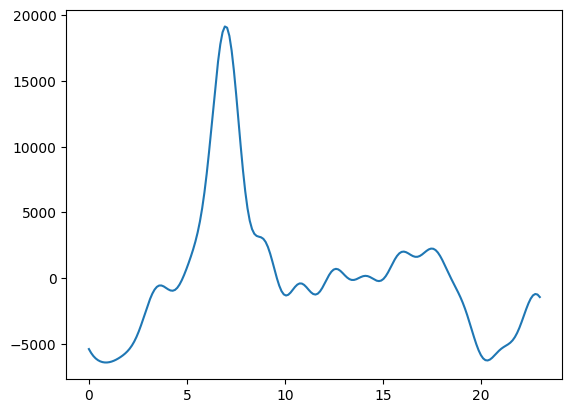

In [327]:
all_results[54]["Weekdays"]["y_pred"]
plt.plot(all_results[54]["Weekdays"]["hours"], all_results[54]["Weekdays"]["y_pred"] )

In [328]:
joined_eval["hour"] = pd.to_datetime(joined_eval["End_Time"]).dt.hour
joined_eval["Group"] = np.where(joined_eval["weekday"].isin(range(0,5)), "Weekdays",
                        np.where(joined_eval["weekday"] == 5, "Saturdays", "Sundays"))

In [329]:
joined_eval.head()

,Grid_ID,End_Time,Sum_Volume,Vol_diff,weekday,hour,Group,y_pred,pred_diff,date,cumsum_pred_diff,new_pred,new_pred_diff
0,3.0,2024-07-01 00:00:00,843.0,0.0,0,0,Weekdays,-380.220808,380.220808,2024-07-01,380.220808,-395.429640,395.429640
1,3.0,2024-07-01 01:00:00,627.0,-216.0,0,1,Weekdays,-193.777180,-22.222820,2024-07-01,357.997988,-208.693763,-7.306237
2,3.0,2024-07-01 02:00:00,340.0,-287.0,0,2,Weekdays,-159.521905,-127.478095,2024-07-01,230.519893,-169.544509,-117.455491
3,3.0,2024-07-01 03:00:00,241.0,-99.0,0,3,Weekdays,-69.956138,-29.043862,2024-07-01,201.476031,-79.114139,-19.885861
4,3.0,2024-07-01 04:00:00,183.0,-58.0,0,4,Weekdays,-8.911123,-49.088877,2024-07-01,152.387154,-16.167654,-41.832346


In [340]:
may_eval["hour"] = pd.to_datetime(may_eval["End_Time"]).dt.hour
may_eval["Group"] = np.where(may_eval["weekday"].isin(range(0,5)), "Weekdays",
                        np.where(may_eval["weekday"] == 5, "Saturdays", "Sundays")) 

In [330]:
joined_eval["y_pred"] = np.nan  # placeholder

for grid_id, grid_results in all_results.items():
    for group, res in grid_results.items():
        hours_fit = res["hours"]        # smooth grid (200 points between 0–23)
        y_fit = res["y_pred"]           # Fourier fit values

        # Interpolate onto discrete hours 0–23
        for hour in range(24):
            pred_val = interp(hour, hours_fit, y_fit)

            mask = (
                (joined_eval["Grid_ID"] == grid_id) &
                (joined_eval["Group"] == group) &
                (joined_eval["hour"] == hour)
            )
            joined_eval.loc[mask, "y_pred"] = pred_val

In [341]:
may_eval["y_pred"] = np.nan  # placeholder

for grid_id, grid_results in all_results.items():
    for group, res in grid_results.items():
        hours_fit = res["hours"]        # smooth grid (200 points between 0–23)
        y_fit = res["y_pred"]           # Fourier fit values

        # Interpolate onto discrete hours 0–23
        for hour in range(24):
            pred_val = interp(hour, hours_fit, y_fit)

            mask = (
                (may_eval["Grid_ID"] == grid_id) &
                (may_eval["Group"] == group) &
                (may_eval["hour"] == hour)
            )
            may_eval.loc[mask, "y_pred"] = pred_val

In [342]:
joined_eval["pred_diff"] = joined_eval["Vol_diff"] - joined_eval["y_pred"]  
may_eval["pred_diff"] = may_eval["Vol_diff"] - may_eval["y_pred"]

In [332]:
joined_eval["date"] = joined_eval["End_Time"].dt.date
joined_eval["cumsum_pred_diff"] = joined_eval.groupby(
    ["Grid_ID", "date"]
)["pred_diff"].cumsum()

In [343]:
may_eval["date"] = may_eval["End_Time"].dt.date
may_eval["cumsum_pred_diff"] = may_eval.groupby(
    ["Grid_ID", "date"]
)["pred_diff"].cumsum()

In [333]:
joined_eval["new_pred"] = joined_eval["y_pred"] - (joined_eval["cumsum_pred_diff"]/(25-joined_eval["hour"]) )  

In [334]:
joined_eval["new_pred_diff"] = joined_eval["Vol_diff"] - joined_eval["new_pred"]    

In [344]:
may_eval["new_pred"] = may_eval["y_pred"] - (may_eval["cumsum_pred_diff"]/(25-may_eval["hour"]) )
may_eval["new_pred_diff"] = may_eval["Vol_diff"] - may_eval["new_pred"]

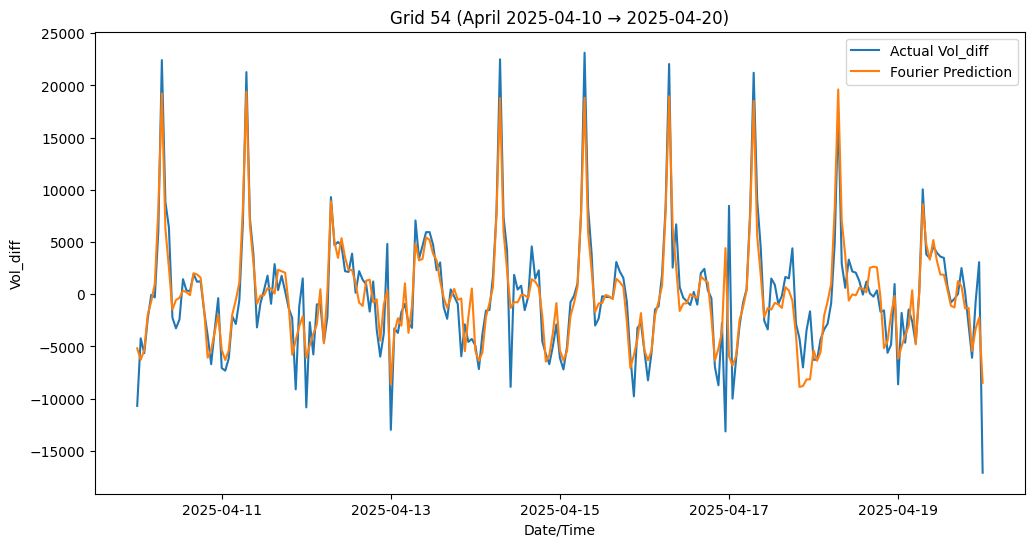

In [335]:
joined54= joined_eval[joined_eval["Grid_ID"] == 54]
# Define your date range
start_date = "2025-04-10"
end_date   = "2025-04-20"

# Filter April data for Grid 54
joined54_April = joined54[
    (joined54["End_Time"] >= pd.to_datetime(start_date)) &
    (joined54["End_Time"] <= pd.to_datetime(end_date))
]

# Plot actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(joined54_April["End_Time"], joined54_April["Vol_diff"], label="Actual Vol_diff")
plt.plot(joined54_April["End_Time"], joined54_April["new_pred"], label="Fourier Prediction")
plt.xlabel("Date/Time")
plt.ylabel("Vol_diff")
plt.title(f"Grid 54 (April {start_date} → {end_date})")
plt.legend()
plt.show()    

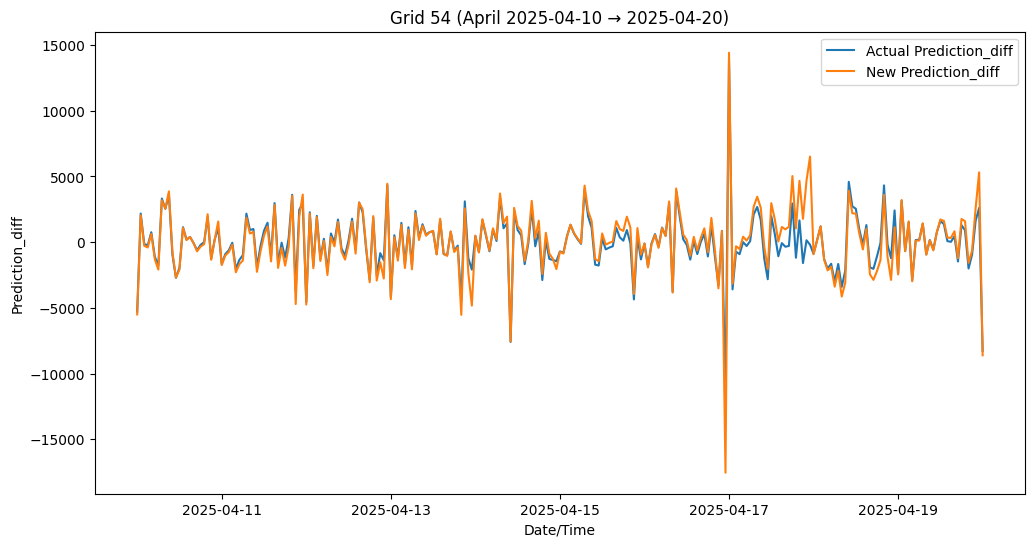

In [336]:

# Plot actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(joined54_April["End_Time"], joined54_April["pred_diff"], label="Actual Prediction_diff")
plt.plot(joined54_April["End_Time"], joined54_April["new_pred_diff"], label="New Prediction_diff")

plt.xlabel("Date/Time")
plt.ylabel("Prediction_diff")
plt.title(f"Grid 54 (April {start_date} → {end_date})")
plt.legend()
plt.show() 

In [337]:
records = []

for group, df in joined_eval.groupby("Group"):
    for pred_col in ["y_pred", "new_pred"]:
        if pred_col not in df:
            continue  # skip if missing

        rmse = np.sqrt(mean_squared_error(df["Vol_diff"], df[pred_col]))
        r2 = r2_score(df["Vol_diff"], df[pred_col])

        records.append({
            "Group": group,
            "Prediction": pred_col,
            "RMSE": rmse,
            "R2": r2
        })

FitEval = pd.DataFrame(records)

In [338]:
FitEval

,Group,Prediction,RMSE,R2
0,Saturdays,y_pred,575.251804,0.784302
1,Saturdays,new_pred,634.534680,0.737553
2,Sundays,y_pred,638.734105,0.744064
3,Sundays,new_pred,702.536354,0.690380
4,Weekdays,y_pred,845.814173,0.772506
5,Weekdays,new_pred,940.662181,0.718624


In [345]:
records_may = []

for group, df in may_eval.groupby("Group"):
    for pred_col in ["y_pred", "new_pred"]:
        if pred_col not in df:
            continue  # skip if missing

        rmse = np.sqrt(mean_squared_error(df["Vol_diff"], df[pred_col]))
        r2 = r2_score(df["Vol_diff"], df[pred_col])

        records_may.append({
            "Group": group,
            "Prediction": pred_col,
            "RMSE": rmse,
            "R2": r2
        })

FitEvalMay = pd.DataFrame(records_may)




In [346]:
FitEvalMay

,Group,Prediction,RMSE,R2
0,Saturdays,y_pred,662.499409,0.747538
1,Saturdays,new_pred,746.072903,0.679825
2,Sundays,y_pred,541.647753,0.801146
3,Sundays,new_pred,597.897233,0.757700
4,Weekdays,y_pred,734.105151,0.828084
5,Weekdays,new_pred,805.243137,0.793151


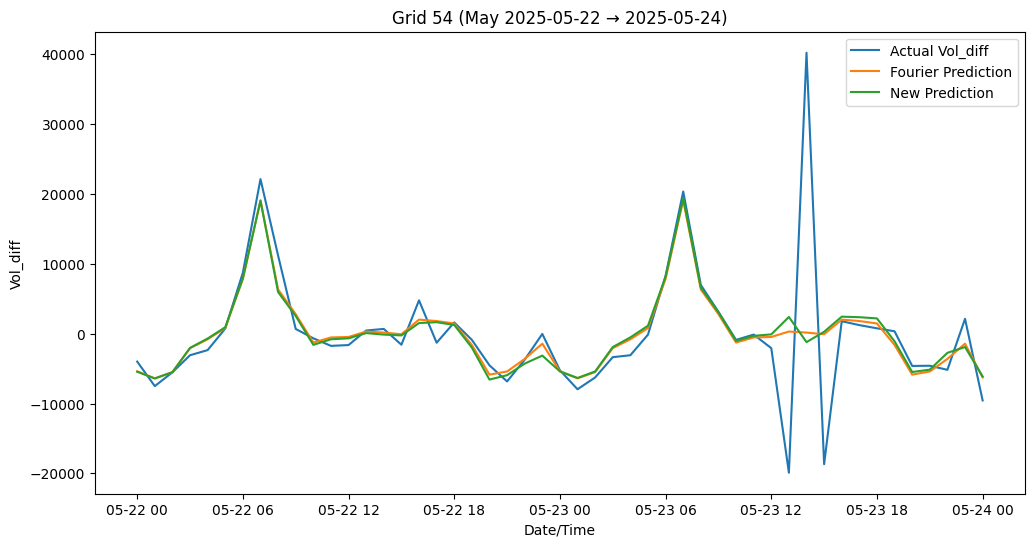

In [351]:
may54= may_eval[may_eval["Grid_ID"] == 54]
# Define your date range
start_date = "2025-05-22"
end_date   = "2025-05-24"

# Filter May data for Grid 54
may54_May = may54[
    (may54["End_Time"] >= pd.to_datetime(start_date)) &
    (may54["End_Time"] <= pd.to_datetime(end_date))
]

# Plot actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(may54_May["End_Time"], may54_May["Vol_diff"], label="Actual Vol_diff")
plt.plot(may54_May["End_Time"], may54_May["y_pred"], label="Fourier Prediction")
plt.plot(may54_May["End_Time"], may54_May["new_pred"], label="New Prediction")
plt.xlabel("Date/Time")
plt.ylabel("Vol_diff")
plt.title(f"Grid 54 (May {start_date} → {end_date})")
plt.legend()
plt.show()    

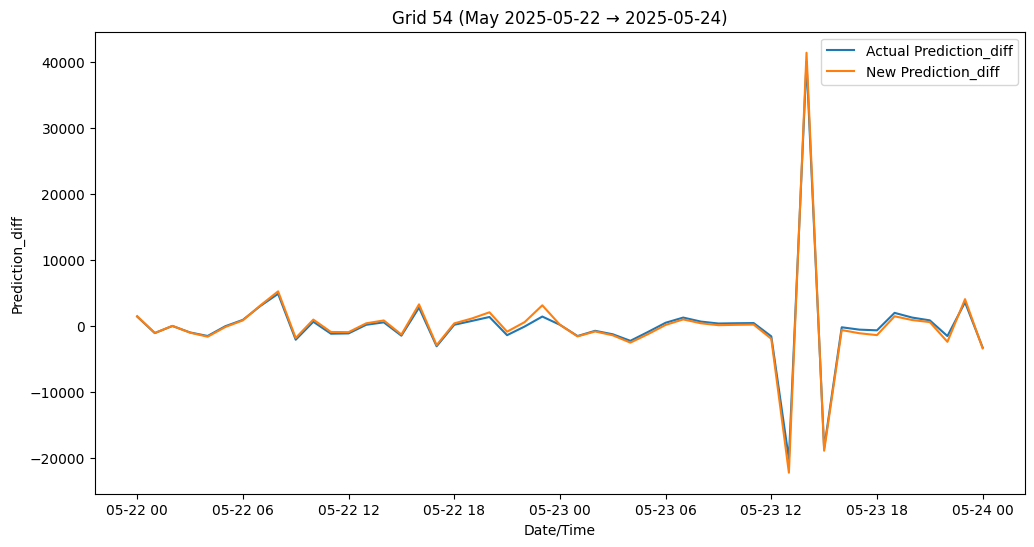

In [350]:
plt.figure(figsize=(12,6))
plt.plot(may54_May["End_Time"], may54_May["pred_diff"], label="Actual Prediction_diff")
plt.plot(may54_May["End_Time"], may54_May["new_pred_diff"], label="New Prediction_diff")

plt.xlabel("Date/Time")
plt.ylabel("Prediction_diff")
plt.title(f"Grid 54 (May {start_date} → {end_date})")
plt.legend()
plt.show() 

In [355]:
ar1_params = {}

for grid_id, grid_results in all_results.items():
    for label, res in grid_results.items():
        # Residuals from Fourier fit in training data
        df = joined_eval[
            (joined_eval["Grid_ID"] == grid_id) &
            (joined_eval["Group"] == label)
        ].copy()

        if df.empty:
            continue

        df["residual"] = df["Vol_diff"] - df["y_pred"]

        resid = df["residual"].dropna()

       # build lagged series
        r = resid.shift(1).dropna()
        r_next = resid.loc[r.index]  # align indices!


        if len(r) < 5:
            continue

        model = sm.OLS(r_next, sm.add_constant(r)).fit()

        ar1_params[(grid_id, label)] = {
            "alpha": model.params[0],
            "phi": model.params[1]
        }

C:\Users\user1\AppData\Local\Temp\ipykernel_10676\1482260489.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "alpha": model.params[0],
C:\Users\user1\AppData\Local\Temp\ipykernel_10676\1482260489.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "phi": model.params[1]
C:\Users\user1\AppData\Local\Temp\ipykernel_10676\1482260489.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "alpha": model.params[0],
C:\Users\user1\AppD

In [364]:
def apply_ar1_correction_global(df, ar1_params):
    """
    Apply AR(1) correction to entire may_eval dataframe.
    Returns a copy with improved_pred column.
    """
    df = df.copy()
    df["improved_pred"] = np.nan
    
    for (grid_id, label), params in ar1_params.items():
        alpha, phi = params["alpha"], params["phi"]

        mask = (df["Grid_ID"] == grid_id) & (df["Group"] == label)
        if not mask.any():
            continue

        sub = df.loc[mask].copy()
        sub = sub.sort_values("End_Time")  # ensure time order

        last_resid = 0
        improved = []

        for _, row in sub.iterrows():
            last_resid = alpha + phi * last_resid
            improved.append(row["y_pred"] + last_resid)

        df.loc[mask, "improved_pred"] = improved
    
    return df

In [365]:
may_eval = apply_ar1_correction_global(may_eval, ar1_params)


In [367]:
for group, df in may_eval.groupby("Group"):
    rmse_y = np.sqrt(mean_squared_error(df["Vol_diff"], df["y_pred"]))
    r2_y = r2_score(df["Vol_diff"], df["y_pred"])

    rmse_improved = np.sqrt(mean_squared_error(df["Vol_diff"], df["improved_pred"]))
    r2_improved = r2_score(df["Vol_diff"], df["improved_pred"])

    print(f"{group}:")
    print(f"  Fourier   -> RMSE={rmse_y:.3f}, R²={r2_y:.3f}")
    print(f"  Improved  -> RMSE={rmse_improved:.3f}, R²={r2_improved:.3f}")

Saturdays:
  Fourier   -> RMSE=662.499, R²=0.748
  Improved  -> RMSE=662.457, R²=0.748
Sundays:
  Fourier   -> RMSE=541.648, R²=0.801
  Improved  -> RMSE=541.637, R²=0.801
Weekdays:
  Fourier   -> RMSE=734.105, R²=0.828
  Improved  -> RMSE=734.120, R²=0.828
